# Television bigrams

If this is your first time running this notebook, you might need to download data first
(see the `DownloadData` notebook).

https://blog.gdeltproject.org/announcing-the-television-news-ngram-datasets-tv-ngram/

In [1]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
%matplotlib inline
nlp = spacy.load("en_core_web_sm")

### Load files from data directory

In [2]:
files = list(map(lambda f: os.path.join('data', f), os.listdir('./data')))

In [3]:
def read_csv(filename):
    """ utility to produce a dataframe given a TV bigram file (gzip tsv) """
    df = pd.read_csv(filename, sep='\t', header=None)
    df.columns = ['date', 'station', 'hour', 'phrase', 'count']    
    return df

In [4]:
bigram_files = list(filter(lambda f: '2gram' in f, files))
unigram_files = list(filter(lambda f: '1gram' in f, files))
bigram_files_to_use = sorted(bigram_files)

In [5]:
%%time
df = pd.concat(map(read_csv, bigram_files_to_use))

CPU times: user 36.7 s, sys: 6.98 s, total: 43.7 s
Wall time: 44 s


In [6]:
def bytesto(bytes, to, bsize=1024):
    """
    https://gist.github.com/shawnbutts/3906915
    convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a[to]):
        r = r / bsize
    return(r)

df_bytes = sys.getsizeof(df)
print(f"df size in MB: {round(bytesto(df_bytes, 'm'))}")

df size in MB: 7916


In [7]:
df['date'].min(), df['date'].max()

(20190401, 20191102)

### Process the data

In [8]:
with open('./NameDatabases/NamesDatabases/first names/all.txt') as f:
    allfnames = f.read()
firstnames = set(map(lambda s: s.lower(), allfnames.splitlines()))

In [9]:
# there are bunch of weird names like 'r', 'j', etc
for char in 'abcdefghijklmnopqrstuvwxyz':
    if char in firstnames:
        firstnames.remove(char)
# other firstnames that should be ignored
ignore_firstnames = [
    'justice', 'washington', 'liberty', 'innocent', 'smart', 'beat',
    'young', 'hong', 'san'
]
for name in ignore_firstnames:
    if name in firstnames:
        firstnames.remove(name)

In [10]:
exclude_words = set([
    'of', 'the', 'this', 'in', 'it', 'is', 'a', 'we', 'on', 'to', 'you', 'who', 'be', 'not', 'for', 'by',
    'i\'m', 'will', 'he', 'her', 'our', 'no', 'from', 'out', 'put', 'like', 'how', 'what', 'where', 'why',
    'do', 'some', 'come', 'but', 'i', 'just', 'so', 'lot', 'more', 'much', 'if', 'did', 'or', 'let\'s',
    'my', 'un', 'see', 'set', 'up', 'ever', 'else', 'goes', 'some', 'over', 'process', 'tell', 'uses',
    'get', 'good', 'shot', 'job', 'even', 'could', 'rules', "'em", 'quote', 'hosts', 'crowd',
    'o', 'u.s.', 'per', 'se', 'me', 'said', 'that', 'an', 'am', 'many', 'long', 'and'
])

has_firstname = lambda bigram: bigram.split(' ')[0] in firstnames
pos_tagging = lambda phrase: [(t, t.pos_) for t in nlp(phrase)]
remove_aps = lambda phrase: phrase[:-2] if phrase.endswith("'s") else phrase
remove_ap = lambda phrase: phrase.replace("'", '')
remove_period = lambda phrase: phrase.replace(".", '')

def contains_exclude_words(phrase):
    w1, w2 = phrase.split(' ')
    return w1 in exclude_words or w2 in exclude_words

remove_all = set(['ADV'])
remove_if_last = set(['VERB'])

if os.path.exists('pos_tagged.pkl'):
    with open('pos_tagged.pkl', 'rb') as f:
        pos_tagged = pickle.load(f)
else:
    pos_tagged = {}
# map: phrase (str) => tags (list) [pos1, pos2]
def pos_tags(phrase):
    if phrase not in pos_tagged:
        tags = [t.pos_ for t in nlp(phrase)]
        pos_tagged[phrase] = tags
    return pos_tagged[phrase]

def has_invalid_all(phrase):
    tags = set(pos_tags(phrase))
    return len(tags & remove_all) > 0

def has_invalid_last(phrase):
    tags = pos_tags(phrase)
    if len(tags) != 2:
        print(phrase)
        print(tags)
    _, tag = tags
    return tag in remove_if_last

has_invalid_pos = lambda phrase: has_invalid_all(phrase) or has_invalid_last(phrase)
has_weird_pos_tags = lambda phrase: len(pos_tags(phrase)) != 2


def get_top_names(df):
    names = df.copy()
    names = names[~names['phrase'].apply(contains_exclude_words)]
    names = names[~names['phrase'].apply(remove_aps).str.contains('\d')] # remove numerics
    names = names[names['phrase'].apply(has_firstname)] # keep the bigrams with a valid firstname
    names['phrase'] = names['phrase'].apply(remove_aps) # remove 's
    names['phrase'] = names['phrase'].apply(remove_ap)  # remove '
    names = names[~names['phrase'].apply(has_weird_pos_tags)]
    names = names[~names['phrase'].apply(has_invalid_pos)] # remove bigrams with invalid POS tags
    return names

In [11]:
%%time
print(len(df))
topnames_df = get_top_names(df)

51463511
CPU times: user 58.9 s, sys: 4.5 s, total: 1min 3s
Wall time: 1min 3s


In [12]:
with open('pos_tagged.pkl', 'wb') as f:
    pickle.dump(pos_tagged, f)

## Data analysis

### See how mentions of people change over time

In [13]:
topnames_df.groupby('phrase')['count'].sum().sort_values(ascending=False).head(n=20)

phrase
donald trump        37292
nancy pelosi        13859
bernie sanders      12992
elizabeth warren    11345
hillary clinton      9176
robert mueller       9035
kamala harris        7460
rudy giuliani        7111
bill barr            6767
adam schiff          5451
mitch mcconnell      4351
pete buttigieg       4125
mike pompeo          3888
william barr         3788
bob mueller          3764
john bolton          3645
hunter biden         3464
lindsey graham       3461
jerry nadler         3441
cory booker          3312
Name: count, dtype: int64

In [14]:
phrase_date_counts = topnames_df.groupby(['phrase', 'date', 'station'], as_index=False) \
    .agg({'count':'sum'}) \
    .loc[lambda df: df['count'] >= 20] \
    .sort_values('date')

phrase_date_counts.head(n=20)

,phrase,date,station,count
117781,ivanka trump,20190401,CNN,29
127368,jesse jackson,20190401,FOXNEWS,29
147344,kim foxx,20190401,FOXNEWS,44
225834,richard nixon,20190401,CNN,47
71463,donald trump,20190401,FOXNEWS,56
76535,el salvador,20190401,FOXNEWS,23
76534,el salvador,20190401,CNN,27
71462,donald trump,20190401,CNN,30
123924,jeff bezos,20190401,CNN,20
23498,bill barr,20190401,CNN,23


In [15]:
phrase_date_counts['date'] = phrase_date_counts['date'].astype(str)
top = phrase_date_counts.groupby('phrase').agg({'count':'sum'}) \
    .sort_values('count', ascending=False).head(n=5)
top

,count
phrase,
donald trump,37203
nancy pelosi,11903
bernie sanders,11042
elizabeth warren,9130
robert mueller,7422


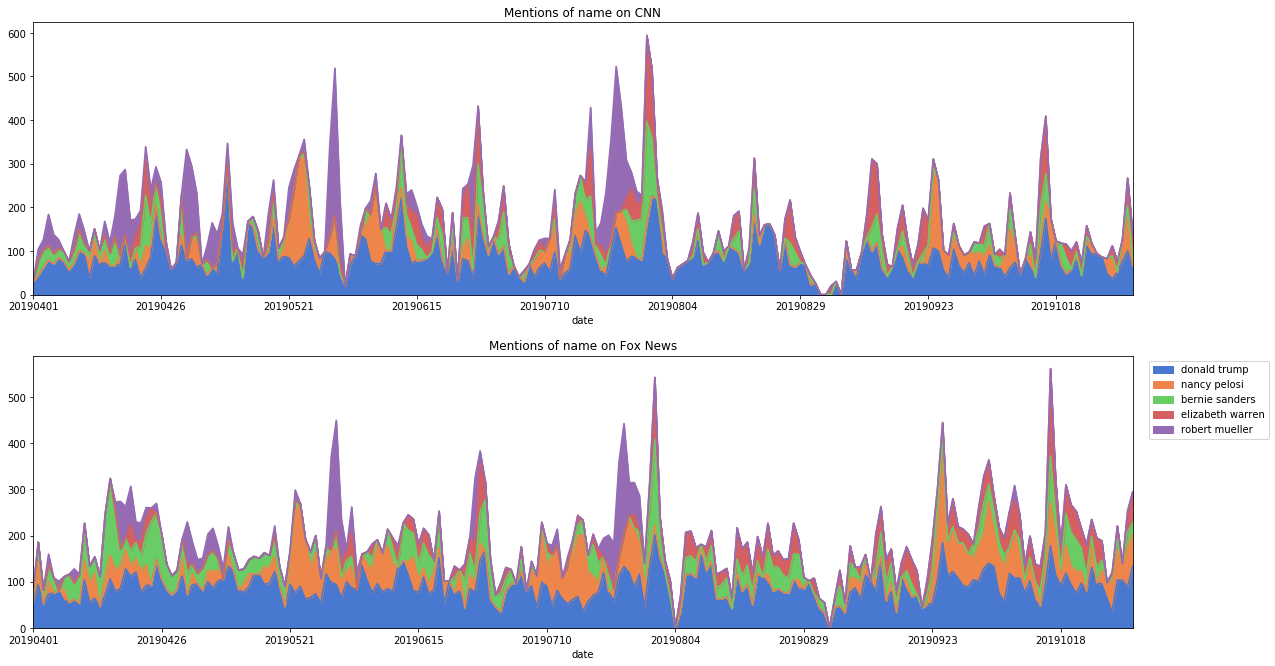

In [16]:
colours = sns.color_palette('muted')
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
plt.tight_layout(h_pad=4)

ax[0].set_title('Mentions of name on CNN')
cnn = phrase_date_counts.loc[lambda d: d['station'] == 'CNN'].groupby('date') \
    .apply(lambda d: pd.merge(top, d, how='left', on='phrase')['count_y'].fillna(0))
cnn.columns = top.index
cnn.plot.area(ax=ax[0], color=colours)\
    .legend_.remove()

ax[1].set_title('Mentions of name on Fox News')
fox = phrase_date_counts.loc[lambda d: d['station'] == 'FOXNEWS'].groupby('date') \
    .apply(lambda d: pd.merge(top, d, how='left', on='phrase')['count_y'].fillna(0))
fox.columns = top.index
p2 = fox.plot.area(ax=ax[1], color=colours)\
    .legend(bbox_to_anchor=(1.01, 1.0))

plt.show()

### See which people are most talked about on one channel but not so much the other

In [17]:
relative_phrases = (
    phrase_date_counts.groupby(['phrase', 'station']).agg({'count':"sum"}).query('count >= 50')
        / phrase_date_counts.groupby('phrase').agg({'count':'sum'})
).query('count != 1')

In [18]:
imbalance = relative_phrases.query('station == "CNN"').reindex().sort_values('count', ascending=False).reset_index()
imbalance.head()

,phrase,station,count
0,maria ramirez,CNN,0.923077
1,justin amash,CNN,0.915385
2,jared kushner,CNN,0.905950
3,paul ryan,CNN,0.899497
4,michael flynn,CNN,0.898455


In [19]:
N = 10
most_cnn = imbalance.head(n=N)['phrase']
most_fox = imbalance.tail(n=N)['phrase']
cnn_msk = phrase_date_counts['phrase'].isin(most_cnn)
fox_msk = phrase_date_counts['phrase'].isin(most_fox)
imbalanced_phrases = phrase_date_counts[cnn_msk | fox_msk].groupby(['phrase','station'])\
    .agg({"count":"sum"}).reset_index().sort_values("count", ascending=False)
imbalanced_phrases.head()

,phrase,station,count
13,hillary clinton,FOXNEWS,4906
1,adam schiff,FOXNEWS,3422
17,hunter biden,FOXNEWS,2060
10,don mcgahn,CNN,2048
12,hillary clinton,CNN,1746


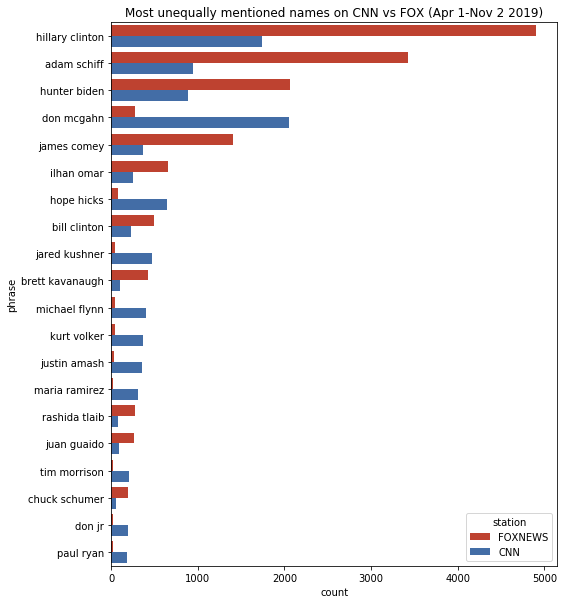

In [20]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_title("Most unequally mentioned names on CNN vs FOX (Apr 1-Nov 2 2019)")

sns.barplot(
    data=imbalanced_phrases,
    y='phrase', x='count',
    hue='station',
    palette=[
        '#d63118', # red for CNN
        '#326bb7'  # blue for FOX
    ]
)
plt.show()